In [7]:
import matplotlib
#matplotlib.use('TKagg')
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
import pandas as pd
import json 
from mpl_toolkits.mplot3d import Axes3D

In [8]:
def json_load(filename):
   with open(filename) as f_in:
       return(json.load(f_in)["mean"]["point_estimate"])

In [9]:
def load_files(dirname):
    folders = os.listdir(dirname)
    #print(folders)
    csv_files = list(map(lambda name: os.path.join(os.path.join(dirname, name),'new/raw.csv'), folders))

    #print(csv_files)


    df_from_each_file = (pd.read_csv(f, sep=',') for f in csv_files)
    #print(list(df_from_each_file))
    df_from_each_file = (f.head(1) for f in df_from_each_file)
    #print(list(df_from_each_file))
    return df_from_each_file


In [10]:
def size_calculation(value):
    element_size = int(value.split("-")[0])
    vector_size = int(value.split("-")[1])
    matrixs_size =  (((32 * element_size * element_size) * 3) * 2) * vector_size
    #normal_elements_size = ((6 * 32 * 1000) + (2 * 32 * 1000) + (6 * 32)) * vector_size
   
    return matrixs_size /8

In [80]:
def merge_csvs(directory):
    dirname = directory

    df_from_each_file = list(load_files(dirname)) 
    df_merged   = pd.concat(df_from_each_file, ignore_index=True)
        

    del df_merged["group"]
    del df_merged["throughput_type"]
    del df_merged["sample_measured_value"]
    del df_merged["unit"]
    del df_merged["iteration_count"]
    folders = df_merged['value']

    df_merged["time"] = list(map(lambda name: json_load(os.path.join(os.path.join(dirname, name),'new/estimates.json')), folders))

    time = df_merged['time']
    value = df_merged['value']
    del df_merged["throughput_num"]
    df_merged['element_size'] = list(map(lambda size:  int(size.split("-")[0]),value))
    df_merged['vector_size'] = list(map(lambda size: int(size.split("-")[1]),value))
    df_merged["throughput_num"] = list(map(lambda v: size_calculation(v), value))
    df_merged['time'] = list(map(lambda value: value/1000000, time))
    df_merged["throughput"] = list(map(lambda ab: float(ab[0]/ab[1]) ,list(zip(df_merged["throughput_num"], df_merged['time']))))
    df_merged['size'] = list(map(lambda value: value/(1024**2), df_merged["throughput_num"]))
    
    entry = df_merged.head().iloc[0]
    
    if entry['function'] == 'tokio' or entry['function'] == 'tokio_seq' :
        values = df_merged[df_merged.value.str.contains(r".*-36$")]
        values['value'] = list(map(lambda v: v.split("-")[0]+'-'+ v.split("-")[1] ,values['value']))
        return values
    
    
    return df_merged



In [84]:
directories = [
"./benchmarks_schedulers/sequential"
,"./benchmarks_schedulers/sequential_par_iter"
,"./benchmarks_schedulers/parallel_speculative_iter"
,"./benchmarks_schedulers/parallel_speculative_par_iter"
,"./benchmarks_schedulers/speculative"
,"./benchmarks_schedulers/async"
,"./benchmarks_schedulers/tokio"
,"./benchmarks_schedulers/tokio_seq"
]

csvs = list(map(lambda dir:merge_csvs(dir), directories))


<ipython-input-80-a92a9ee1d968>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  values['value'] = list(map(lambda v: v.split("-")[0]+'-'+ v.split("-")[1] ,values['value']))


In [105]:
#common_values = list(set(df1.Col1) & set(df2.Col1) & set(df3.Col1))
from functools import reduce

print(csvs)
values = list(reduce(lambda acc,v: acc & set(v['value']) ,csvs,set(csvs[0]['value'])))

#print(list(values))
#l = csvs[0].loc[csvs[0]['value'].isin(values)]
#print(l)

l = list(map(lambda value: value.loc[value['value'].isin(values)]  ,csvs))

l = list(map(lambda value: value.sort_values(by=["size"], ascending=False)  ,l))

print(l)

[      function     value         time  element_size  vector_size  \
0   sequential    32-600    16.755850            32          600   
1   sequential  256-4800  7128.937259           256         4800   
2   sequential   64-2400   255.795975            64         2400   
3   sequential   32-9600   272.959490            32         9600   
4   sequential    512-96   473.220934           512           96   
..         ...       ...          ...           ...          ...   
69  sequential   512-800  5096.419303           512          800   
70  sequential   256-600   774.676676           256          600   
71  sequential   512-360  1889.064890           512          360   
72  sequential   512-240  1232.091025           512          240   
73  sequential   128-360   118.712966           128          360   

    throughput_num    throughput       size  
0     1.474560e+07  8.800270e+05    14.0625  
1     7.549747e+09  1.059028e+06  7200.0000  
2     2.359296e+08  9.223351e+05   225.0000 

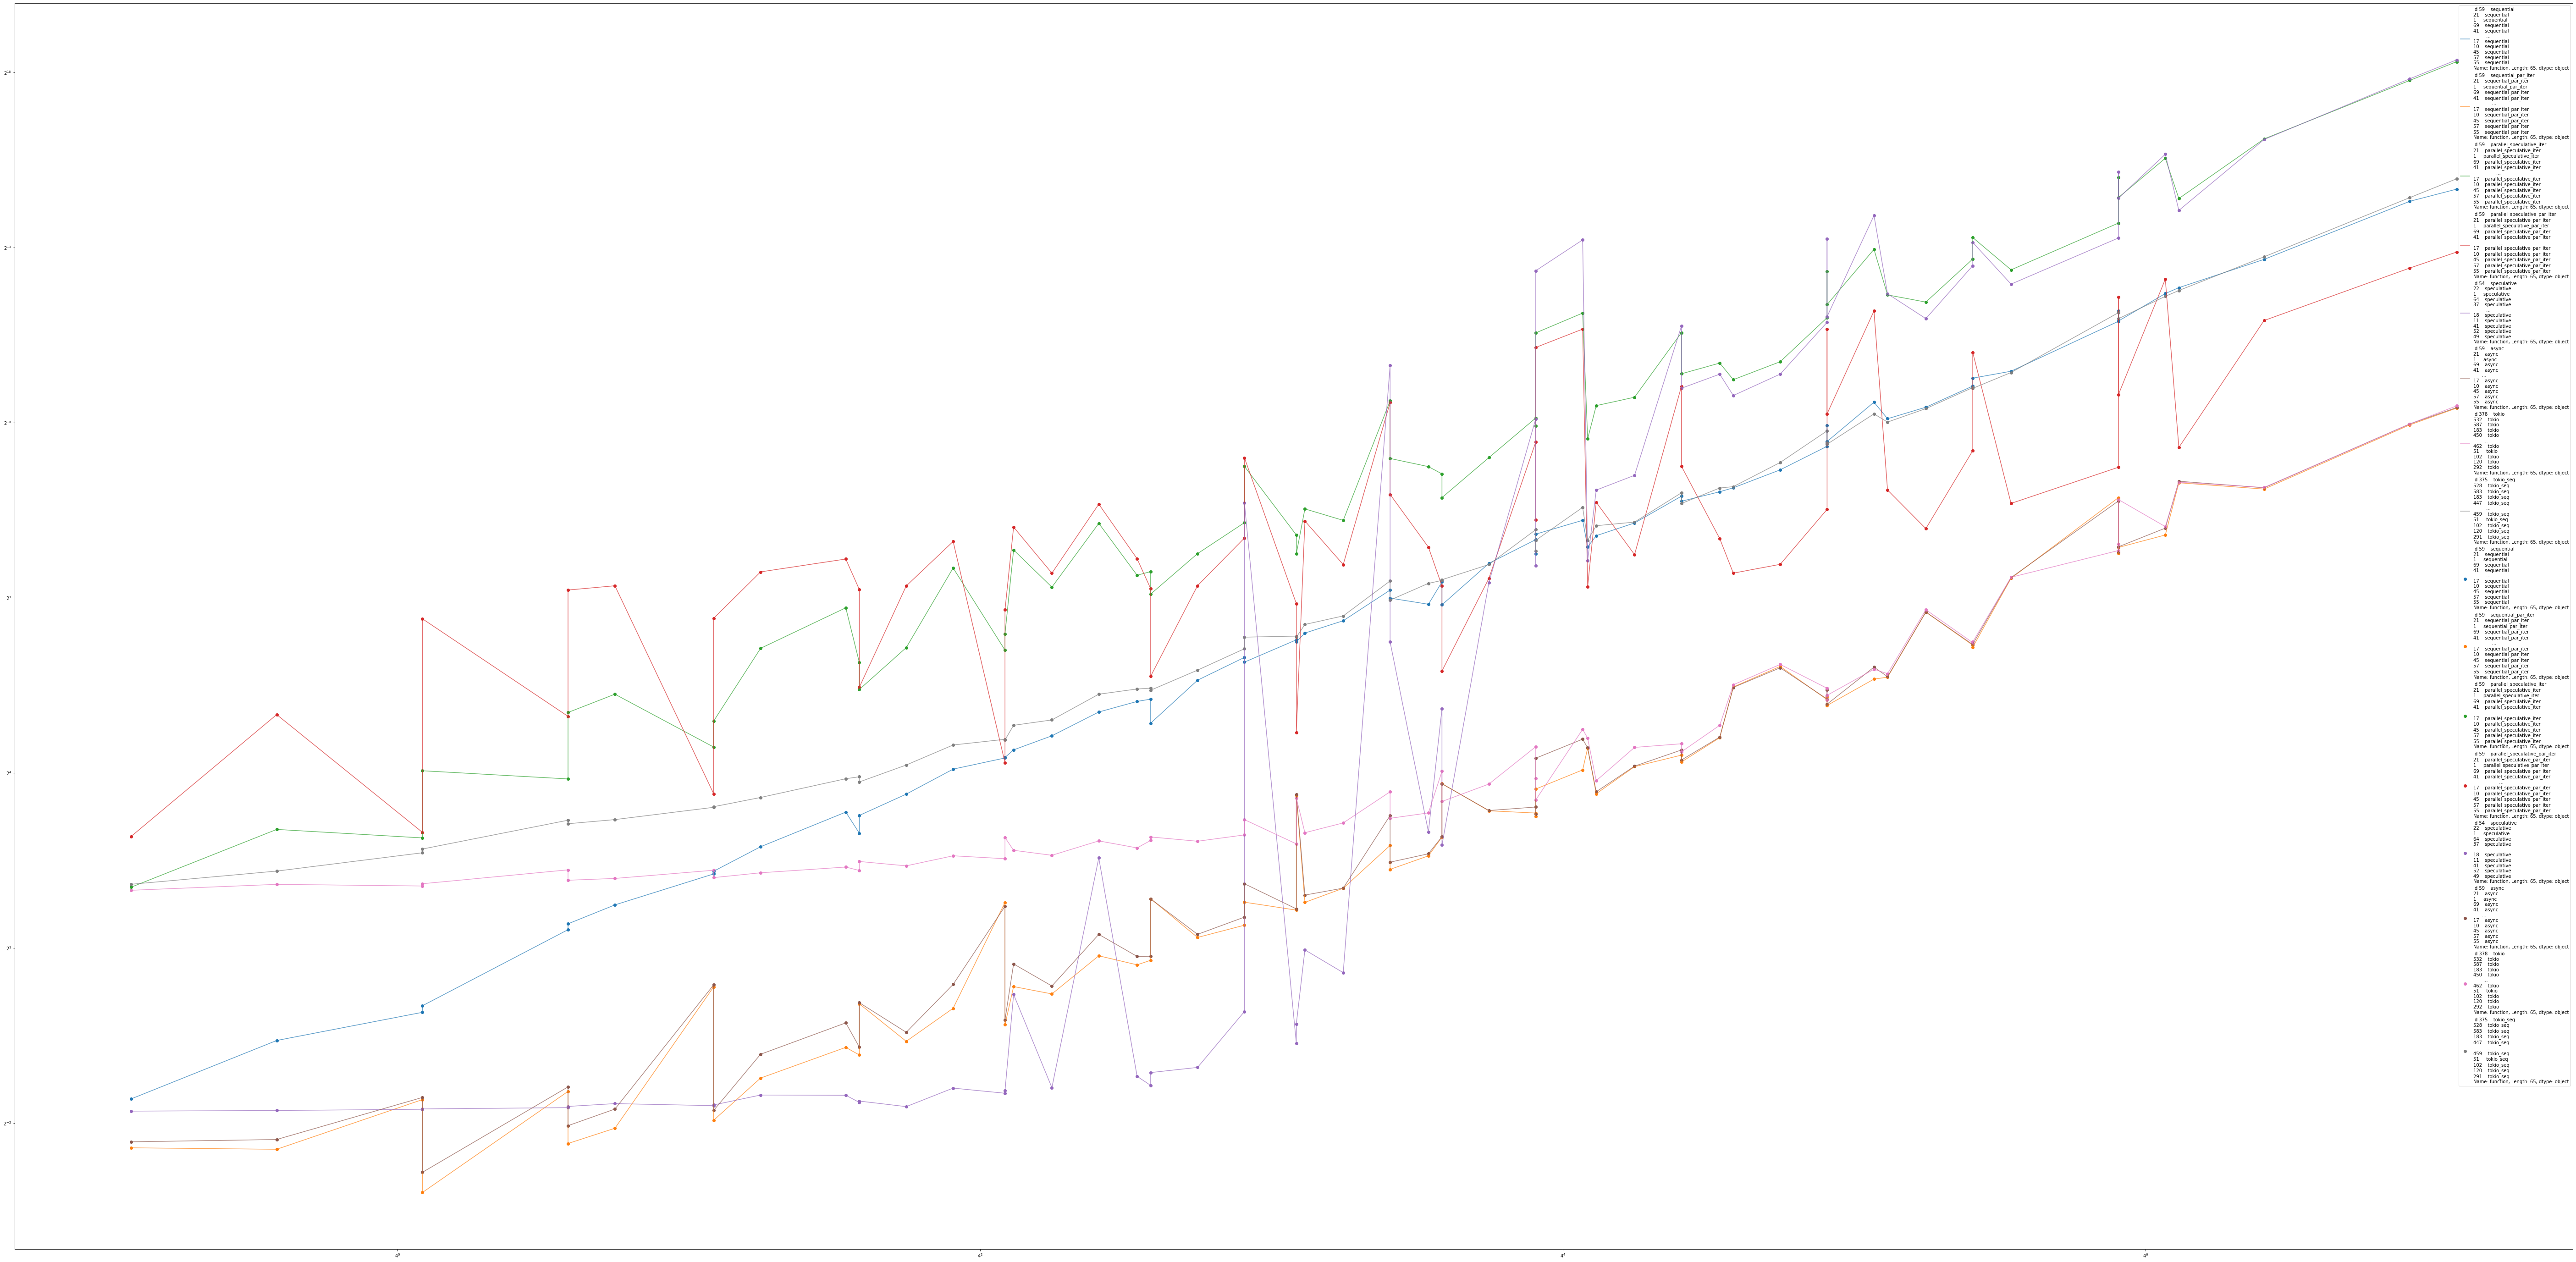

In [120]:
for v  in l :
    plt.scatter(v['size'],v['time'],label = 'id %s'%v['function'])

    plt.plot(v['size'],v['time'],label = 'id %s'%v['function'], alpha=0.7)
plt.legend()
plt.rcParams["figure.figsize"] = (150,50)
plt.xscale('log',base=4) 
plt.yscale('log',base=2) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    


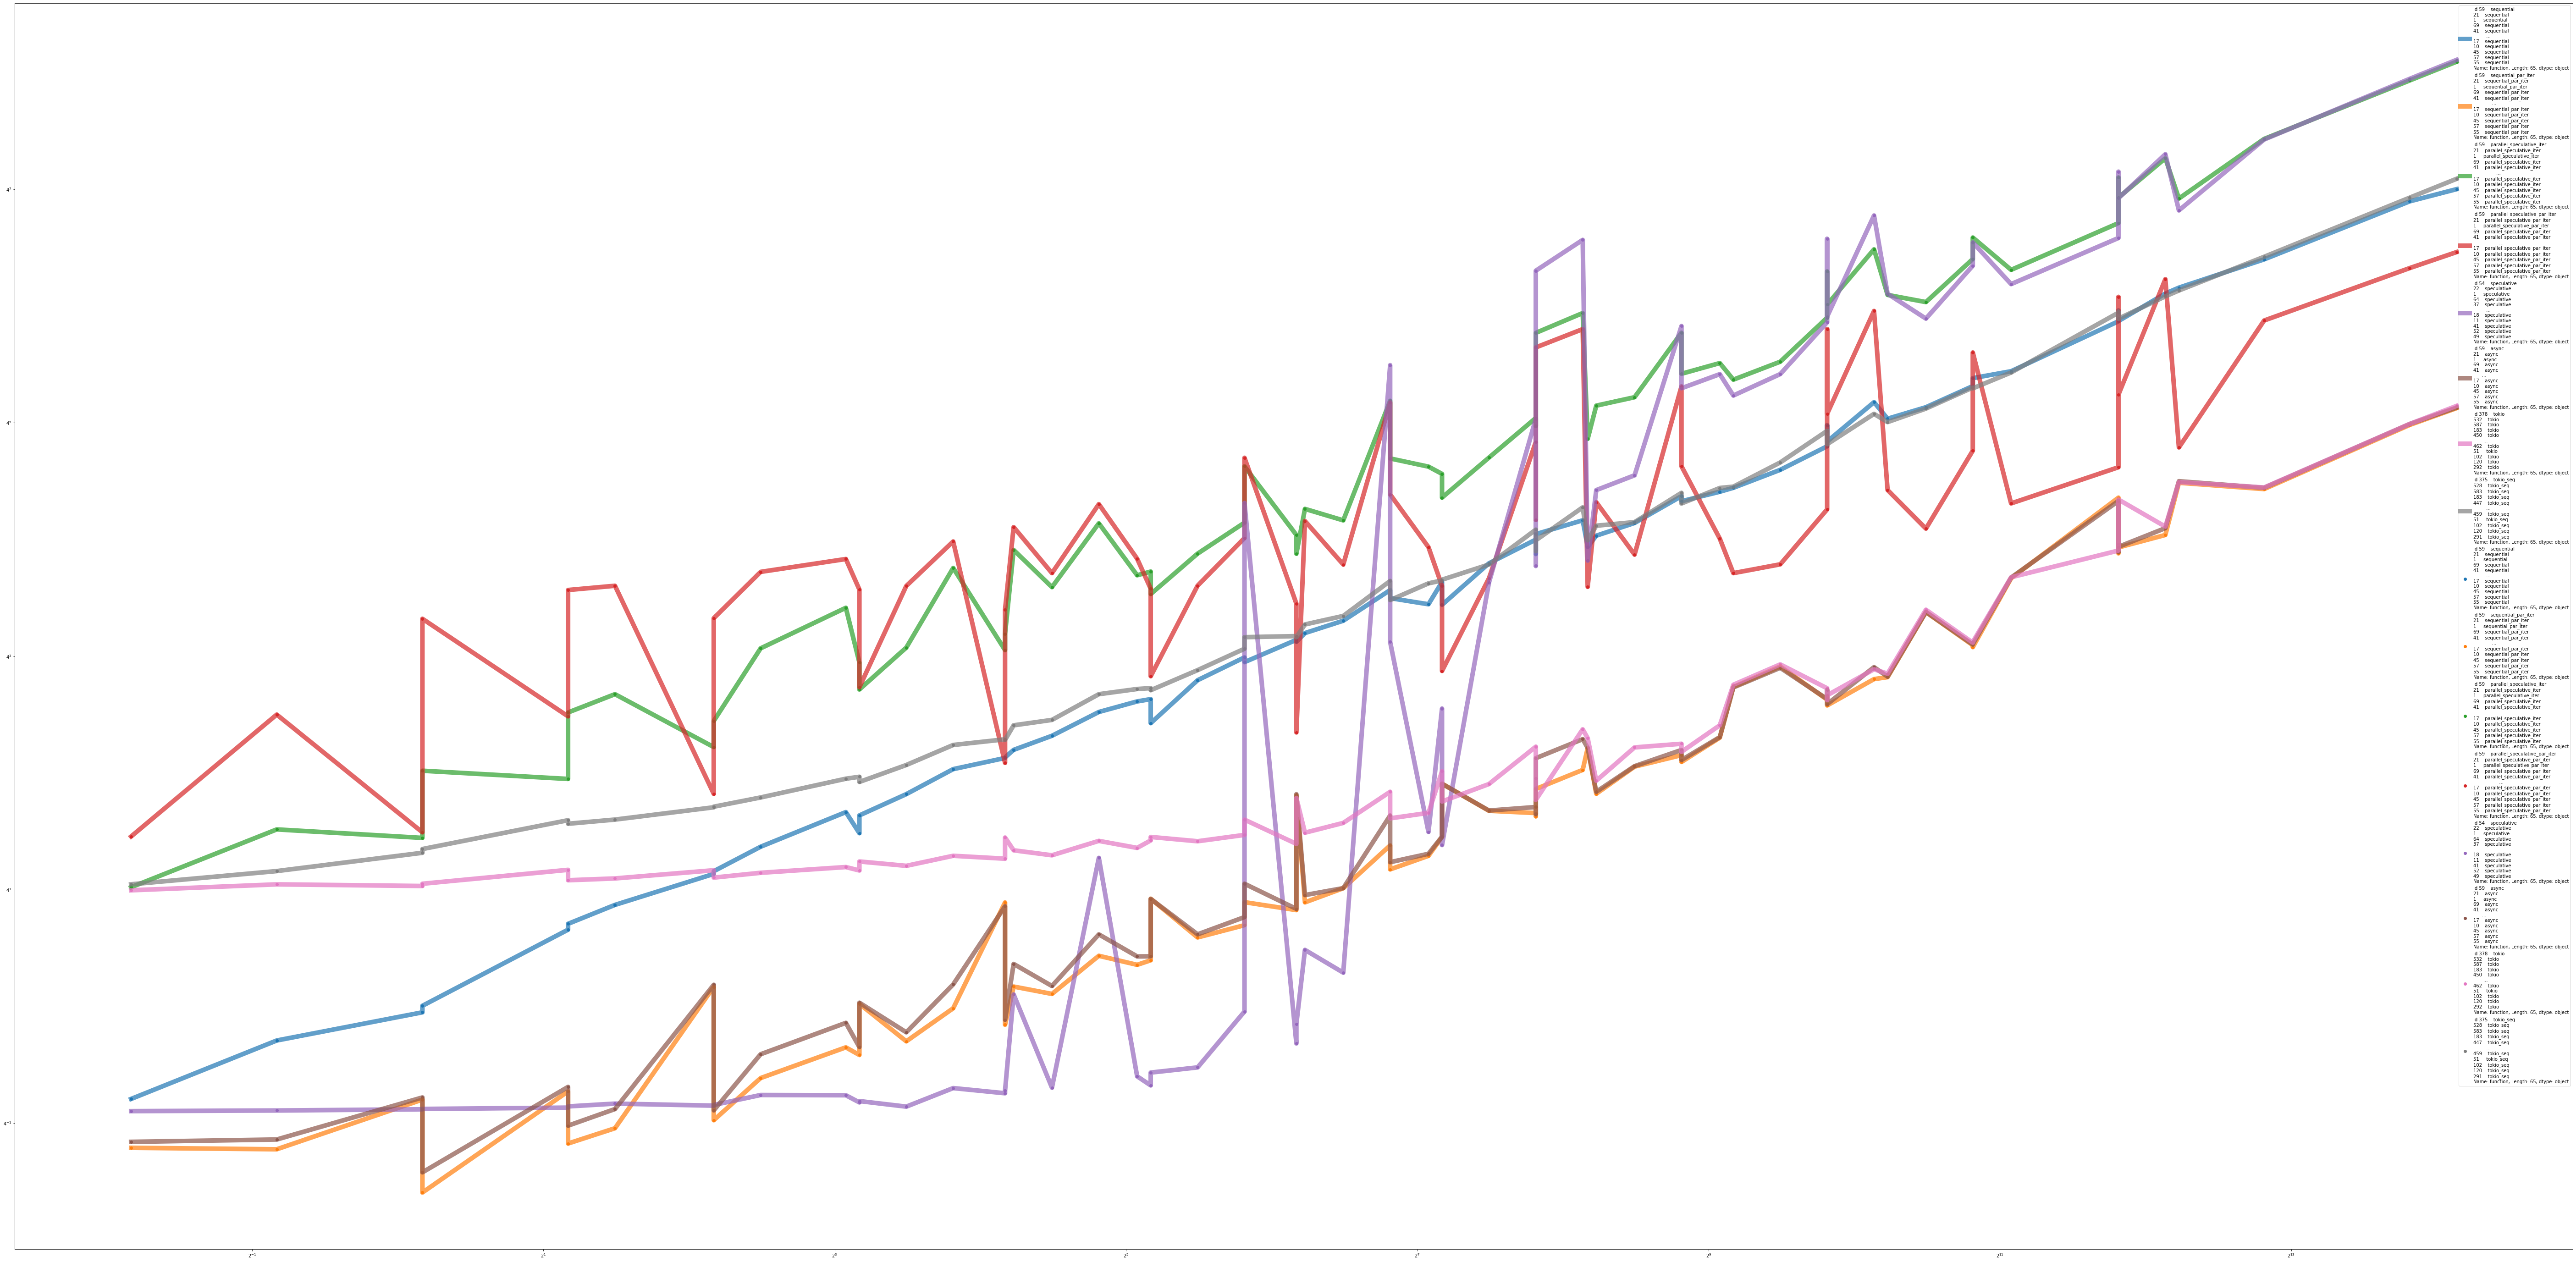

In [103]:
for v  in l :
    plt.scatter(v['size'],v['time'],label = 'id %s'%v['function'])
    plt.plot(v['size'],v['time'],label = 'id %s'%v['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (100,50)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    

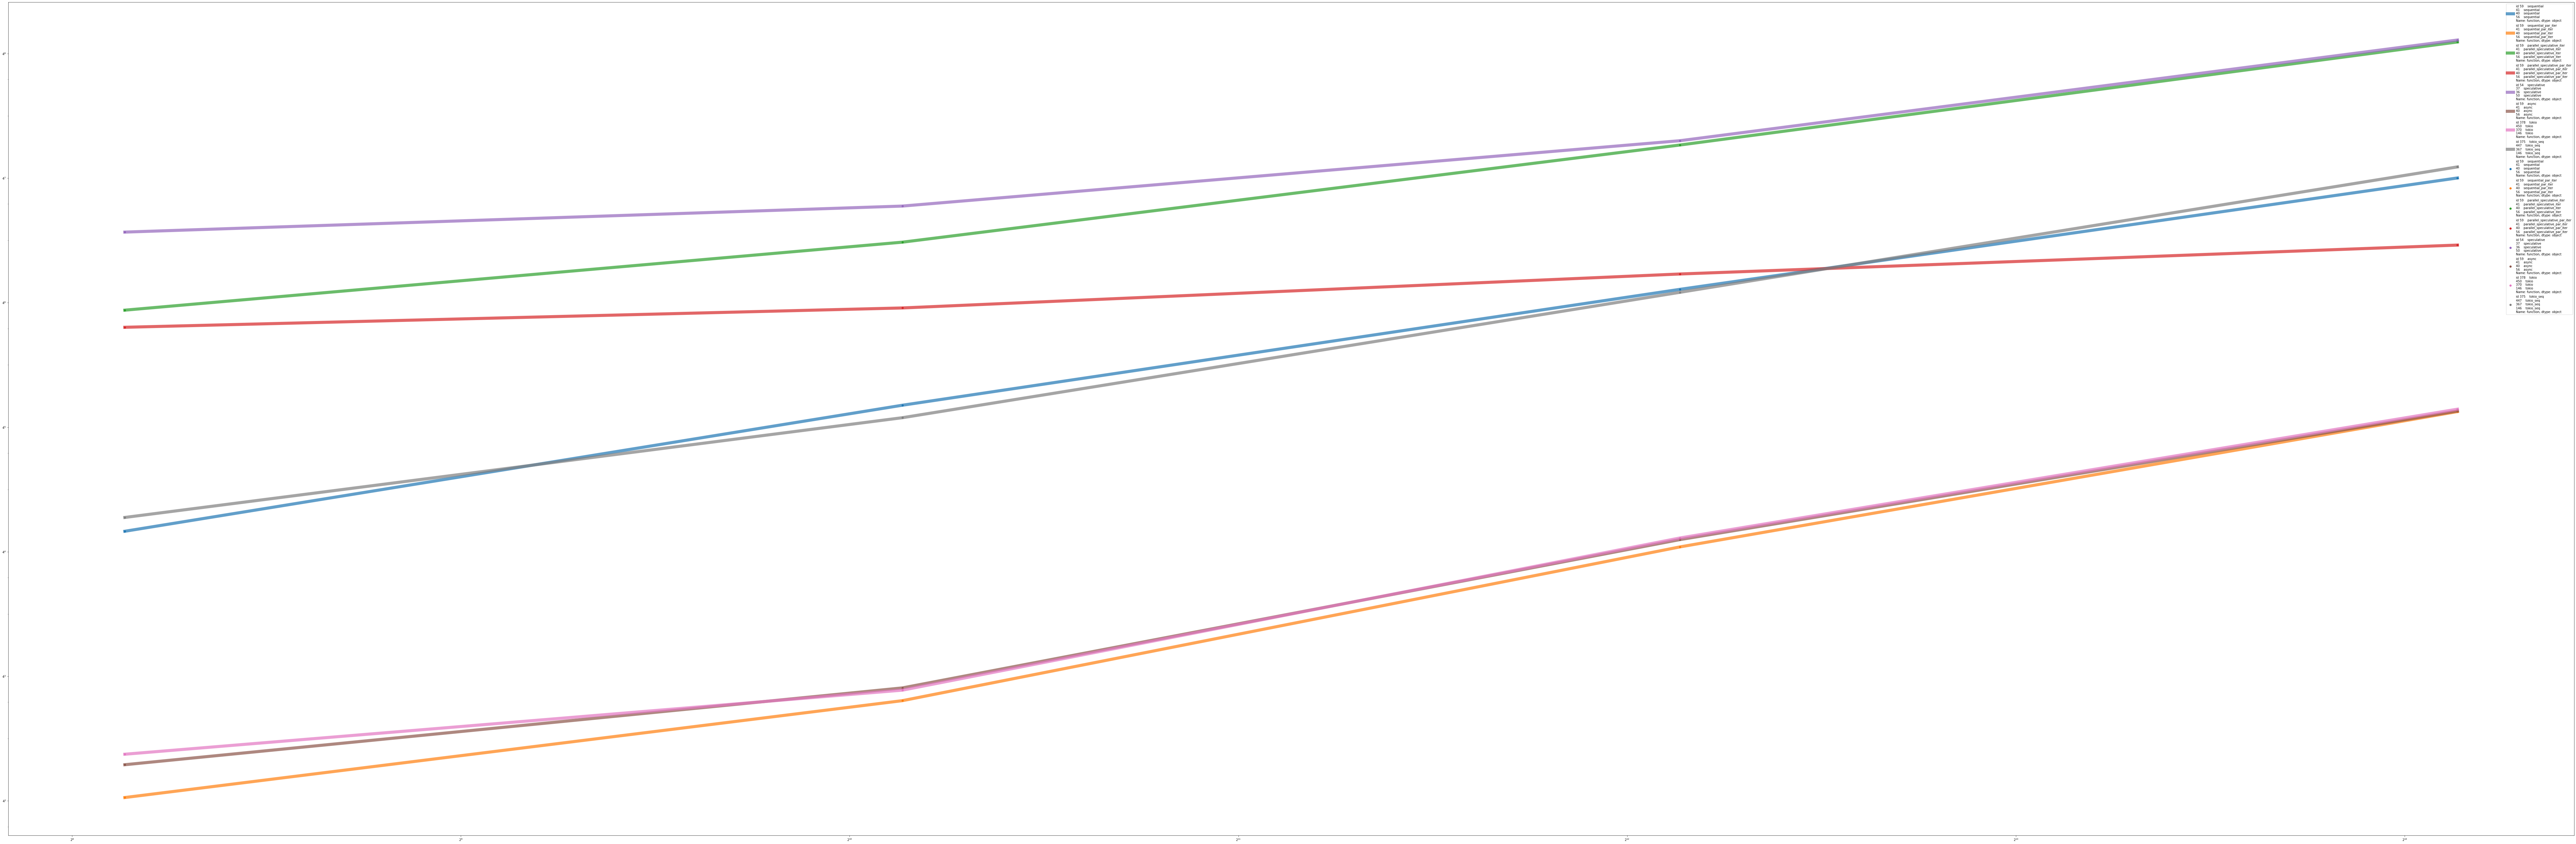

In [117]:
# 256-12000
a = list(map(lambda value: value[value.value.str.contains(r"^.*-12000")],l))

for v  in a :
    plt.scatter(v['size'],v['time'],label = 'id %s'%v['function'])
    plt.plot(v['size'],v['time'],label = 'id %s'%v['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (100,50)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    

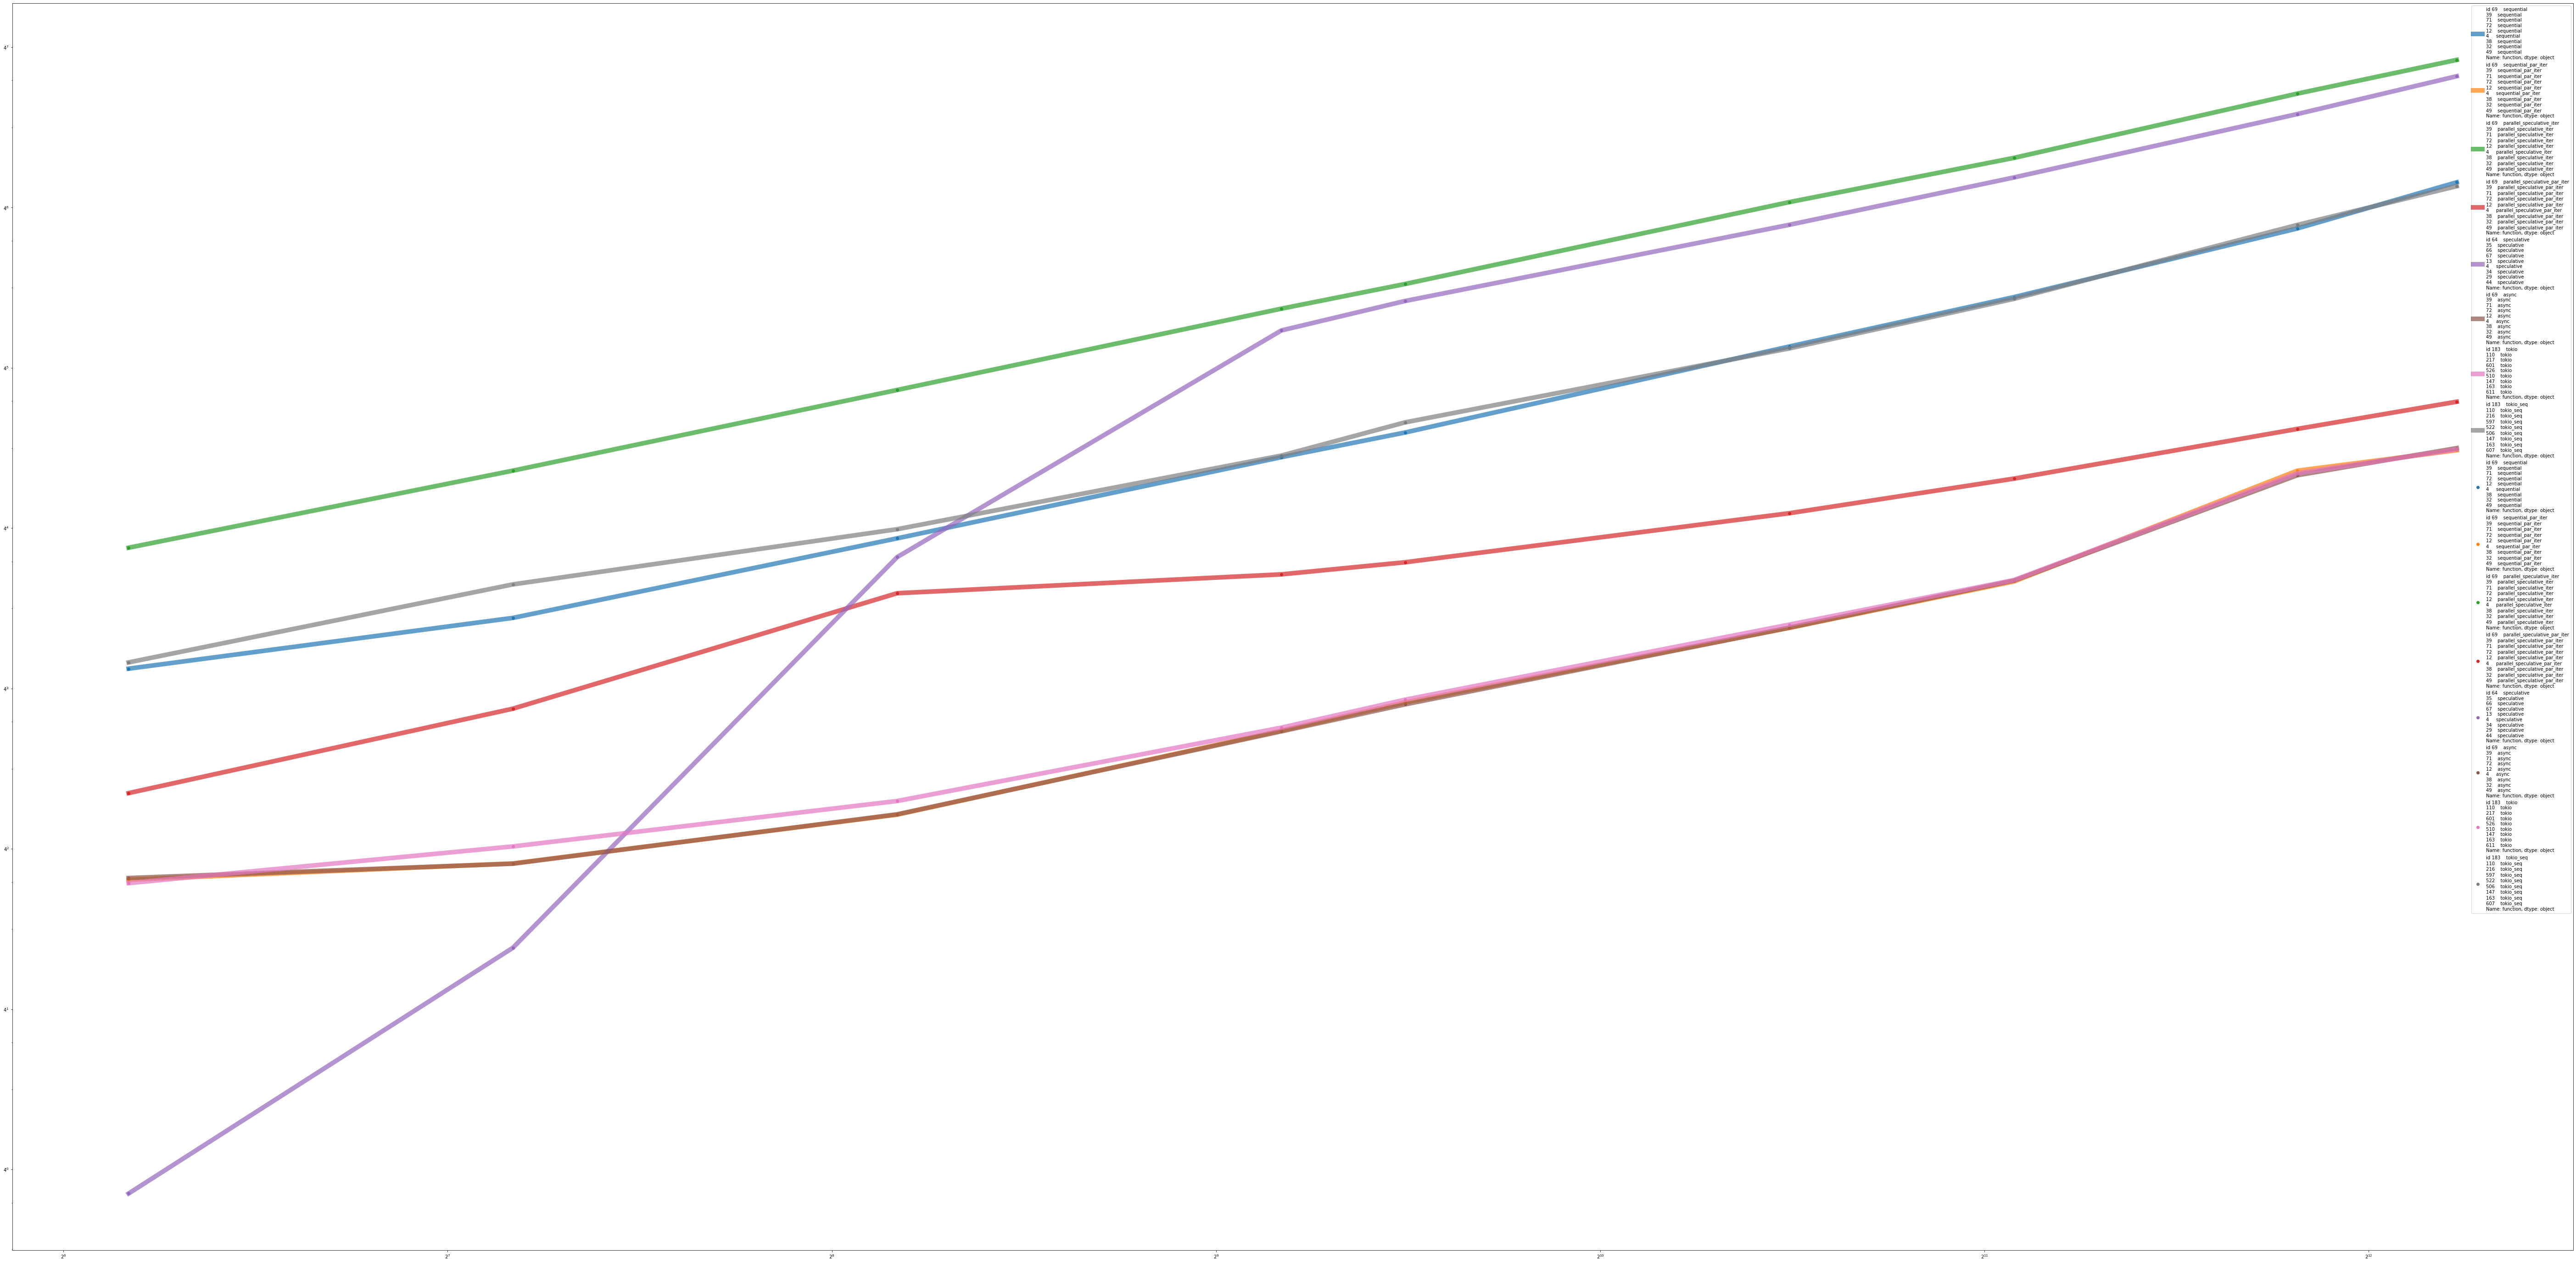

In [118]:
# 512-800

b = list(map(lambda value: value[value.value.str.contains(r"^512-.*")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'],label = 'id %s'%v['function'])
    plt.plot(v['size'],v['time'],label = 'id %s'%v['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (100,50)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    

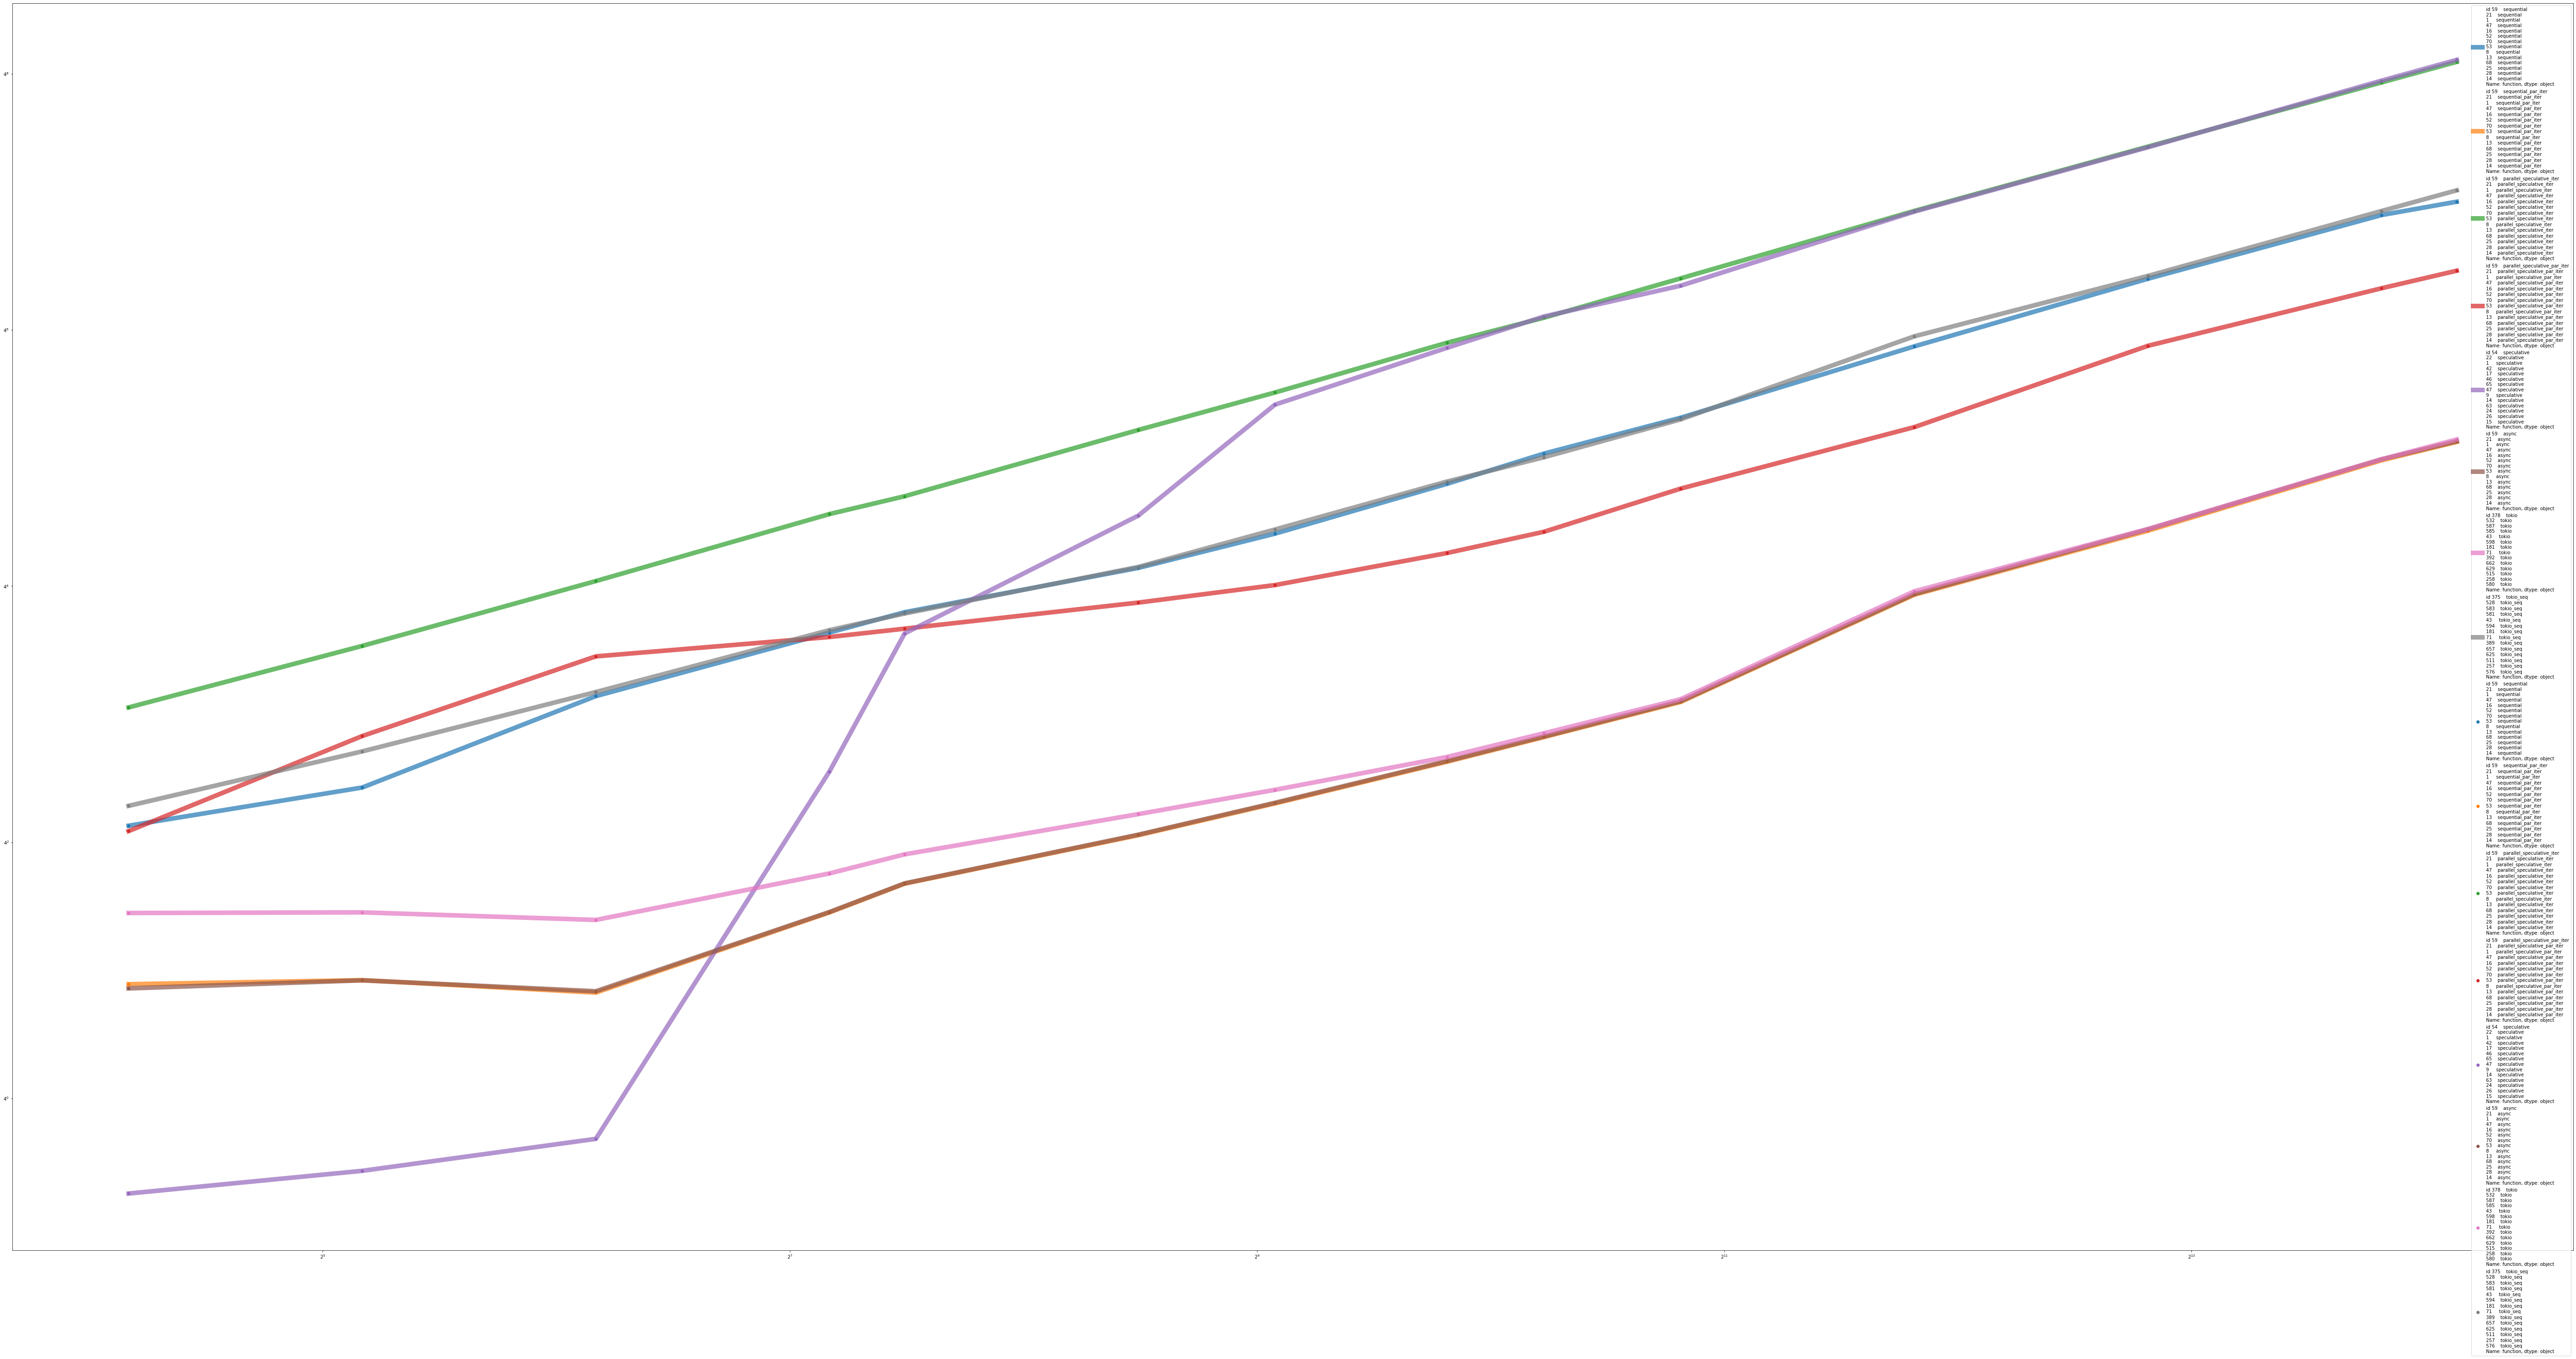

In [119]:
# 512-800

b = list(map(lambda value: value[value.value.str.contains(r"^256-.*")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'],label = 'id %s'%v['function'])
    plt.plot(v['size'],v['time'],label = 'id %s'%v['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (100,50)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    